In [15]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from itertools import product
from loguru import logger
from torch import Tensor
import numpy as np
from matplotlib.patches import FancyArrowPatch


In [2]:
torch.manual_seed(0)

std = 0.1
id_translation = torch.Tensor([1, 0])
ood_translation = torch.Tensor([-1, 0])

feat_s = id_translation + std * torch.randn(50, 2)
feat_i = id_translation + std * torch.randn(50, 2)

feat_o = ood_translation + std * torch.randn(1, 2)

In [3]:
# utilities

def fill_ax(ax, feat_s, feat_i, feat_o, trajectory):
    """
    support : [?, 2]
    feat_i : [?, 2]
    feat_o : [?, 2]
    
    trajectory : [n_iter, 2]
    """
    ax.scatter(feat_s[:, 0], feat_s[:, 1], label='support')
    ax.scatter(feat_i[:, 0], feat_i[:, 1], label='in-distribution')
    ax.scatter(feat_o[:, 0], feat_o[:, 1], label='out-of-distribution')
    
    ax.scatter(trajectory[:, 0], trajectory[:, 1])
    
    for i, (x, y) in enumerate(trajectory):
        ax.annotate(i, (x + 0.05, y + 0.05))

In [4]:
def generate_trajectories(feat_s, feat_i, feat_o):
    """
    Generate multiple trajectories, for multiple initialization points.
    """
    raw_feat_i = feat_i
    raw_feat_o = feat_o
    
    n_iter = 150
    
    all_init = list(product([2, -2], repeat=2))
    trajectories = torch.empty(len(all_init), n_iter, 2)
    
    
    for i, initialization in enumerate(all_init):
        
        mu = torch.tensor(initialization).float().unsqueeze(0) # [1, 2]
        mu.requires_grad_()
        optimizer = torch.optim.SGD([mu], lr=0.1)
        d = raw_feat_i.size(-1)

        for j in range(n_iter):
            
            unorm_feat_i = raw_feat_i - mu
            feat_i = F.normalize(unorm_feat_i, dim=1)  # [?, d]

            feat_o = raw_feat_o - mu
            feat_o = F.normalize(feat_o, dim=1)  # [?, d]

            trajectories[i, j, :] = mu.detach().squeeze()

            sup = feat_s - mu
            sup = F.normalize(sup, dim=1)
            sup = sup.mean(0, keepdim=True)  # [1, d]

            loss = - (feat_i @ sup.t()).mean() + (feat_o @ sup.t()).mean()    

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#             logger.info(f"{i}: {loss.item()}")
        mu = mu.detach()
    return trajectories


## Plotting trajectories

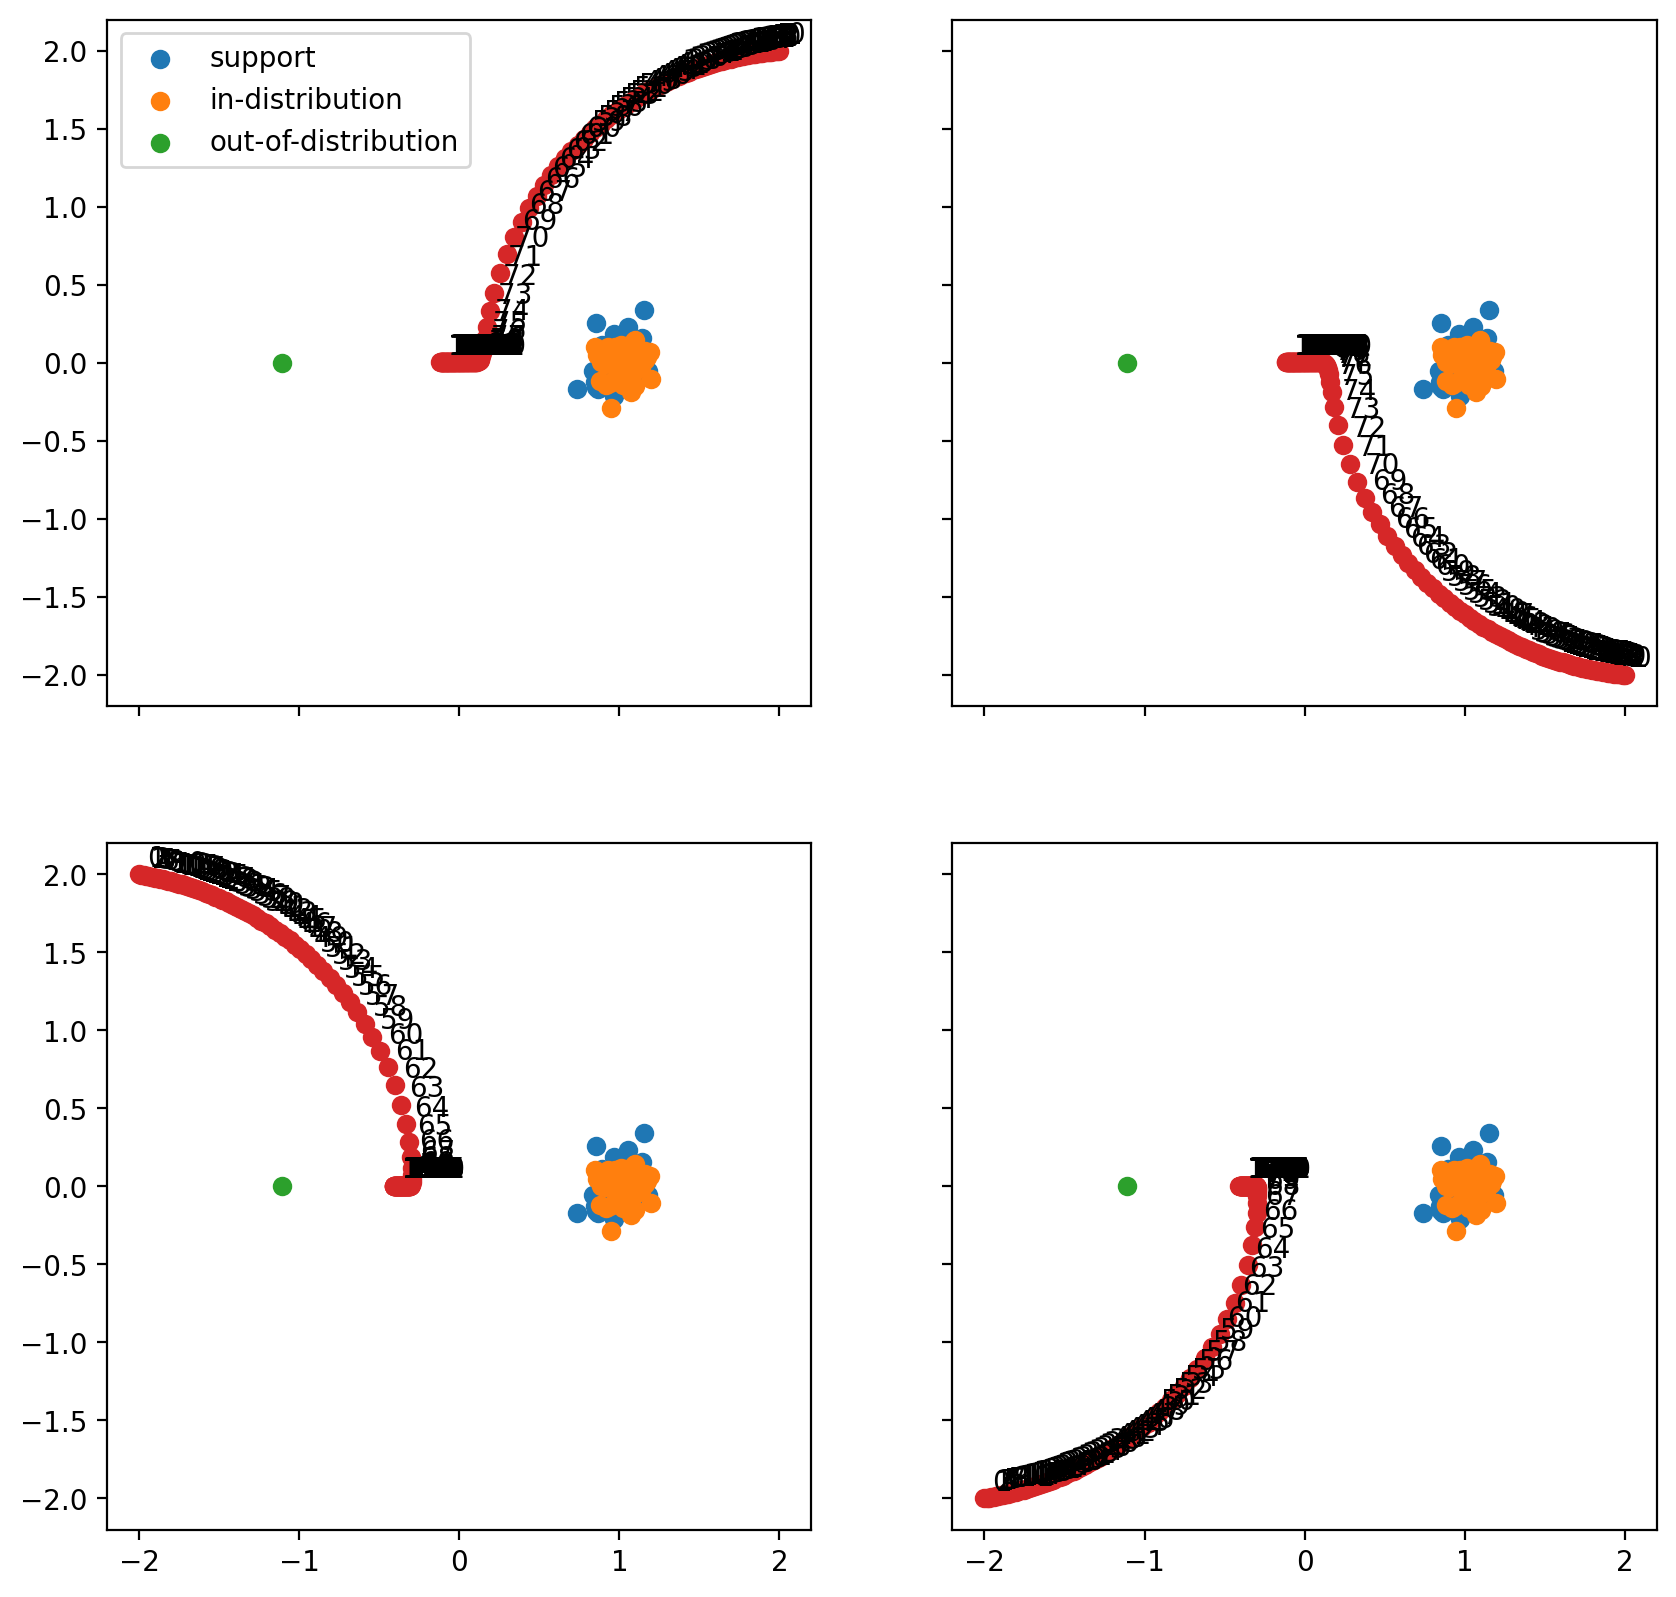

In [6]:
# Main
trajectories = generate_trajectories(feat_s, feat_i, feat_o) # [n_init, n_iter, 2]

f, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True, dpi=200)
for i, (ax, traj) in enumerate(zip(axes.flatten(), trajectories)):
    fill_ax(ax, feat_s, feat_i, feat_o, traj)
    if i==0:
        ax.legend()

# Plotting gradient field

In [11]:
def get_gradient_at(feat_s, feat_i, feat_o, mu_value):
    """
    mu_value: Tensor [2,]
    """
    raw_feat_i = feat_i
    raw_feat_o = feat_o
    
    mu = Tensor(mu_value).float().unsqueeze(0) # [1, 2]
    mu.requires_grad_()
    
    unorm_feat_i = raw_feat_i - mu
    feat_i = F.normalize(unorm_feat_i, dim=1)  # [?, d]

    feat_o = raw_feat_o - mu
    feat_o = F.normalize(feat_o, dim=1)  # [?, d]

    sup = feat_s - mu
    sup = F.normalize(sup, dim=1)
    sup = sup.mean(0, keepdim=True)  # [1, d]

    loss = - (feat_i @ sup.t()).mean() + (feat_o @ sup.t()).mean()    
    loss.backward()

    return mu.grad.squeeze()

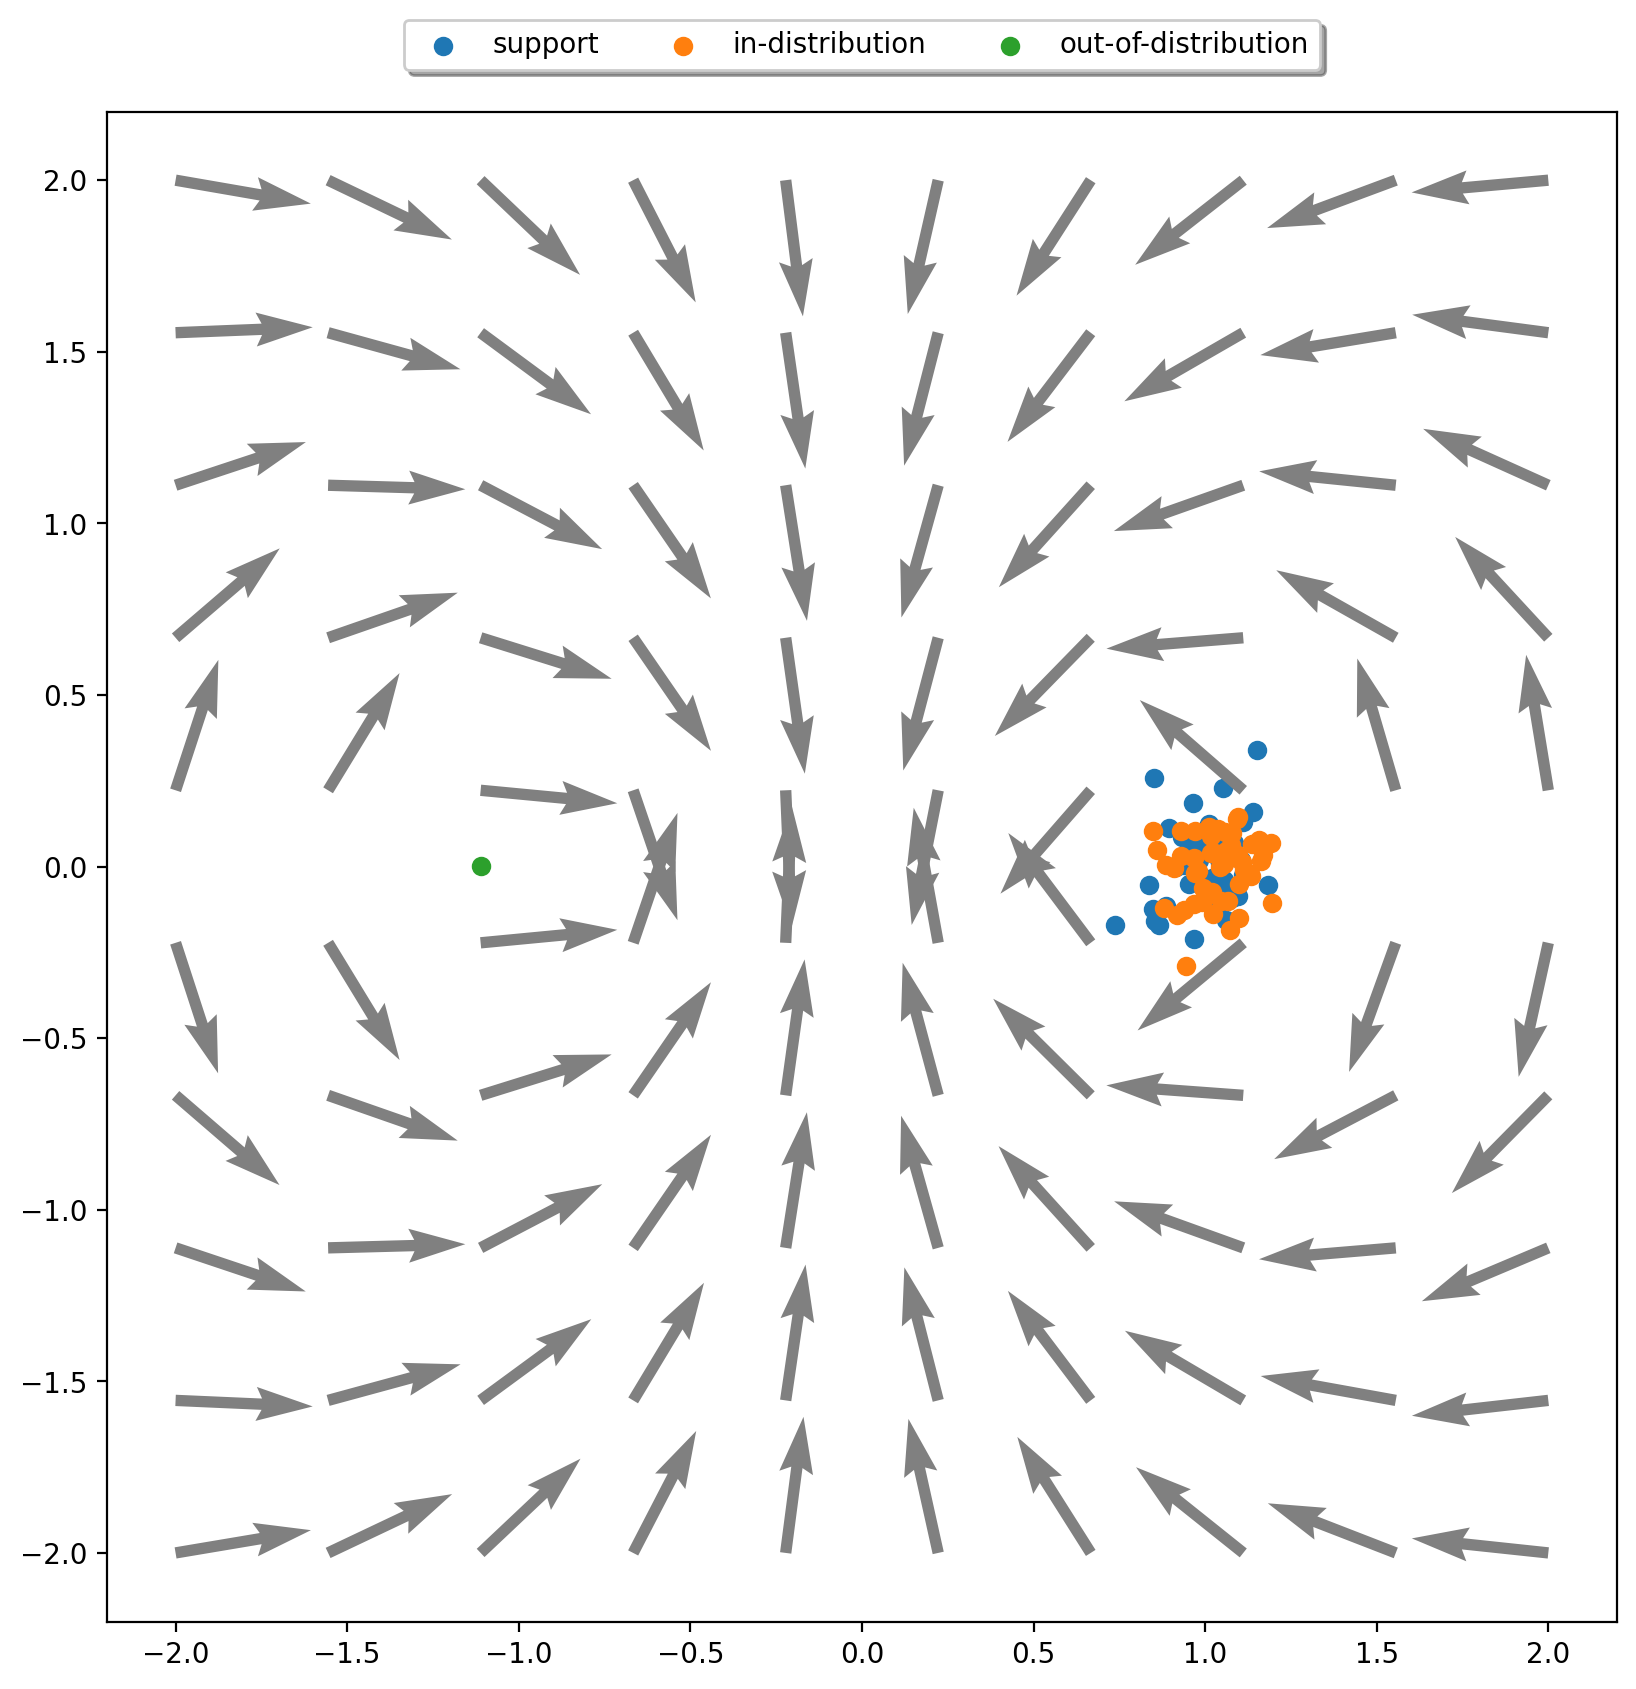

In [35]:
feature_x = np.linspace(-2, 2, 10)
feature_y = np.linspace(-2, 2, 10)

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=200)
ax.set_aspect(1)

ax.scatter(feat_s[:, 0], feat_s[:, 1], label='support')
ax.scatter(feat_i[:, 0], feat_i[:, 1], label='in-distribution')
ax.scatter(feat_o[:, 0], feat_o[:, 1], label='out-of-distribution')
    
grid_x, grid_y = np.meshgrid(feature_x, feature_y)

for (x, y) in zip(grid_x.flatten(), grid_y.flatten()):
    grad = get_gradient_at(feat_s, feat_i, feat_o, torch.Tensor([x, y]))
    grad = - 0.2 *  F.normalize(grad, dim=0)
#     ax.scatter(feature_x, feature_y, c='k')
    ax.quiver(x, y, grad[0], grad[1], units='xy', scale=0.5, color='gray')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
          ncol=3, fancybox=True, shadow=True)

In [102]:
logger.info(f"Gradient at random point : {round(get_gradient_at(feat_s, feat_i, feat_o, torch.randn(2)),3)}")
for lambda_ in torch.linspace(0.1, 0.8, 10):
    centroid =  lambda_ * feat_i.mean(0) + (1 - lambda_) * feat_o.mean(0)
    logger.info(f"Gradient at {round(lambda_.item(),2 )} along the line : {round(get_gradient_at(feat_s, feat_i, feat_o, centroid), 3)}")

2022-02-24 11:27:09.131 | INFO     | __main__:<module>:1 - Gradient at random point : 0.19
2022-02-24 11:27:09.137 | INFO     | __main__:<module>:4 - Gradient at 0.1 along the line : 0.037
2022-02-24 11:27:09.143 | INFO     | __main__:<module>:4 - Gradient at 0.18 along the line : 0.025
2022-02-24 11:27:09.147 | INFO     | __main__:<module>:4 - Gradient at 0.26 along the line : 0.022
2022-02-24 11:27:09.151 | INFO     | __main__:<module>:4 - Gradient at 0.33 along the line : 0.022
2022-02-24 11:27:09.153 | INFO     | __main__:<module>:4 - Gradient at 0.41 along the line : 0.025
2022-02-24 11:27:09.156 | INFO     | __main__:<module>:4 - Gradient at 0.49 along the line : 0.034
2022-02-24 11:27:09.158 | INFO     | __main__:<module>:4 - Gradient at 0.57 along the line : 0.052
2022-02-24 11:27:09.160 | INFO     | __main__:<module>:4 - Gradient at 0.64 along the line : 0.094
2022-02-24 11:27:09.162 | INFO     | __main__:<module>:4 - Gradient at 0.72 along the line : 0.209
2022-02-24 11:27:09

(100,)